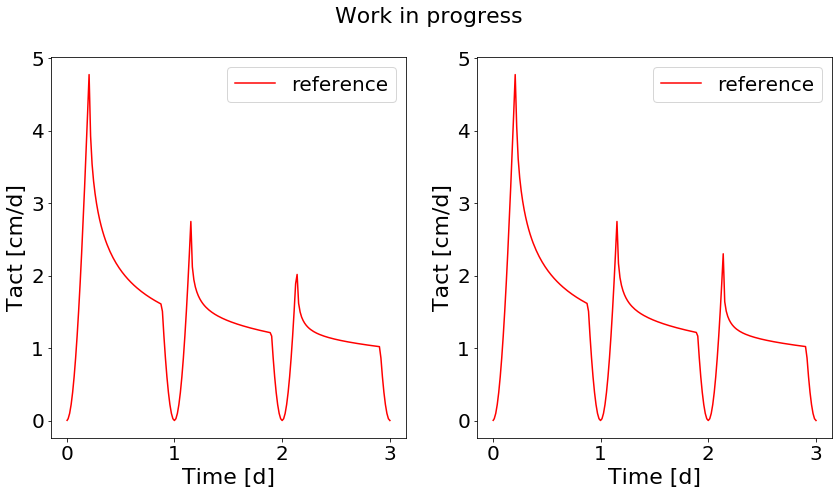

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from math import *
import csv
from pathlib import Path

fig, ax = plt.subplots(1, 2, figsize=(14,7)) 
col = ["r-", "g-", "r-", "g-", "b-"]
# C1.2a
l=[]
for dirname, dirnames, filenames in os.walk('C1.2a Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(Path(f).stem)
            data = np.loadtxt("C1.2a Numerical results/"+f,delimiter=';')           
            pl, = ax[0].plot(data[0,:],data[1,:],col[i])
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)  
ax[0].set_xlabel("Time [d]")  
ax[0].set_ylabel("Tact [cm/d]")  
ax[0].legend(l)    

# C1.2b
l=[]
for dirname, dirnames, filenames in os.walk('C1.2b Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(Path(f).stem)
            data = np.loadtxt("C1.2b Numerical results/"+f,delimiter=';')        
            pl, = ax[1].plot(data[0,:],data[1,:],col[i])
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)  
ax[1].set_xlabel("Time [d]")  
ax[1].set_ylabel("Tact [cm/d]")  
ax[1].legend(l)            


plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.savefig('m32_results.png', dpi=300, bbox_inches = "tight")
fig.suptitle("Work in progress")
plt.show() 